<a href="https://colab.research.google.com/github/meleeshagamage/CourseWork_ML/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1

In [42]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score


print("Libraries loaded")

Libraries loaded


In [2]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Import the dataset
df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Get the shape
print("Shape:", df.shape)
df.info()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

In [5]:
## Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
#Count Missing Values
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [7]:
# Remove customerID column because it can mislead the model
df = df.drop(columns=['customerID'])


### EDA visualizations


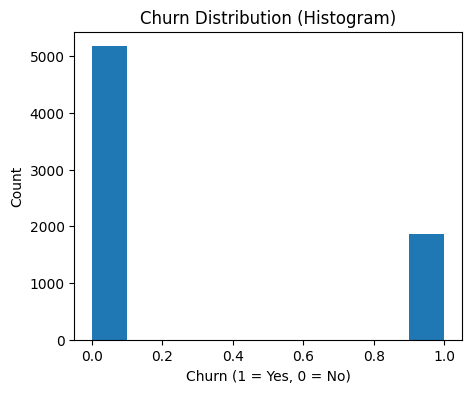

In [8]:
df['Churn_numeric'] = df['Churn'].map({'Yes':1, 'No':0})

plt.figure(figsize=(5,4))
plt.hist(df['Churn_numeric'])
plt.title('Churn Distribution (Histogram)')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()



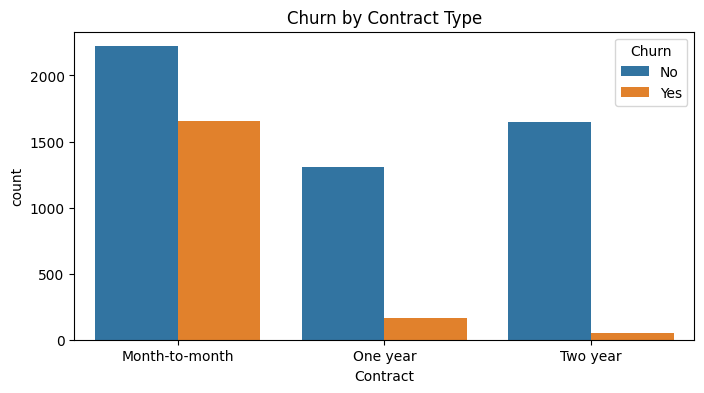

In [9]:
# Churn rate by Contract type
plt.figure(figsize=(8,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()


Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']


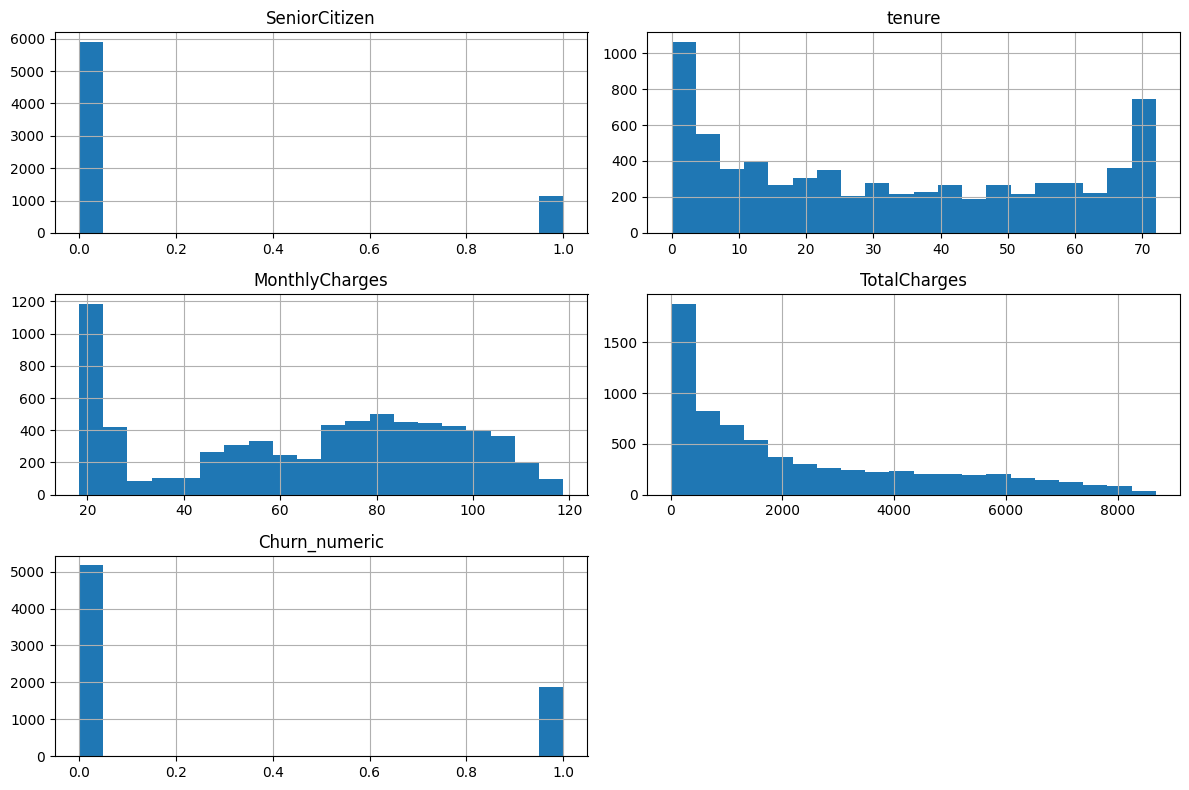

In [10]:
# Numeric columns histograms
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numeric cols:", num_cols)
df[num_cols].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

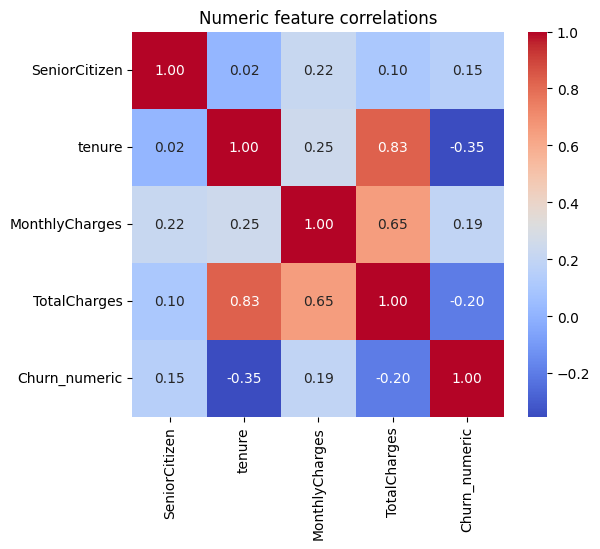

In [11]:
# Correlation heatmap among numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric feature correlations')
plt.show()

/tmp/ipython-input-148596323.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = df.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack()


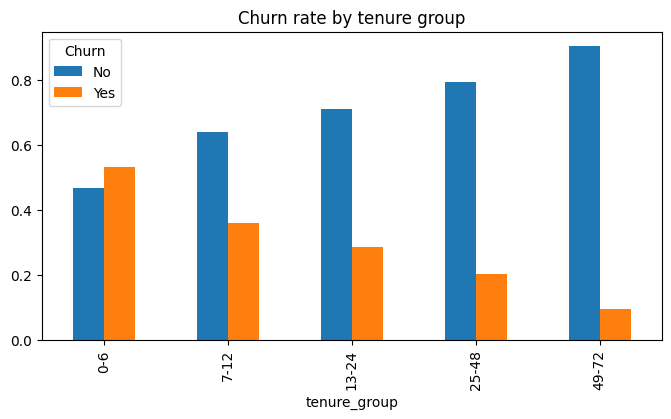

In [12]:
# Churn rate by tenure buckets
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,6,12,24,48,72], labels=['0-6','7-12','13-24','25-48','49-72'])
churn_by_tenure = df.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack()
churn_by_tenure.plot(kind='bar', stacked=False, figsize=(8,4))
plt.title('Churn rate by tenure group')
plt.show()

### Preprocessing & feature engineering

In [13]:
# Fill missing TotalCharges
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [14]:
# Encode target
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

In [15]:
# Identify categorical and numeric cols
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Categorical:", cat_cols)
print("Numeric:", num_cols)


Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_numeric']


In [16]:
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

if 'Churn' in num_cols:
    num_cols.remove('Churn')

In [17]:
# For simplicity, drop 'tenure_group' if created earlier (we'll use tenure numeric and will remove the tenure_group we creared for the visualization task)
if 'tenure_group' in df.columns:
    df = df.drop(columns=['tenure_group'])

In [18]:
# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

### Train-test split

In [19]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [20]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
# After spliting the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5634, 20)
X_test shape: (1409, 20)
y_train shape: (5634,)
y_test shape: (1409,)


In [22]:
# Check class distribution is maintained
print(f"Original churn ratio: {df['Churn'].value_counts(normalize=True)}")
print(f"Train churn ratio: {y_train.value_counts(normalize=True)}")
print(f"Test churn ratio: {y_test.value_counts(normalize=True)}")

Original churn ratio: Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Train churn ratio: Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Test churn ratio: Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


# TASK 2

### Decision Tree with hyperparameter tuning

In [23]:
# Pipeline: preprocessing + Decision Tree
dt_pipeline = Pipeline(steps=[('preproc', preprocessor),
                              ('clf', DecisionTreeClassifier(random_state=42))])

In [24]:
param_grid = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [3,5,8,12,None],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4]
}

grid_dt = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'Churn_numeric']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneH...
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [3, 5, 8, 12, None],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

In [25]:
print("Best Decision Tree parameters:")
print(grid_dt.best_params_)

print("Best CV F1-score:")
print(grid_dt.best_score_)

Best Decision Tree parameters:
{'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV F1-score:
1.0


In [26]:
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:,1]

In [27]:
print("Decision Tree Test metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Test metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



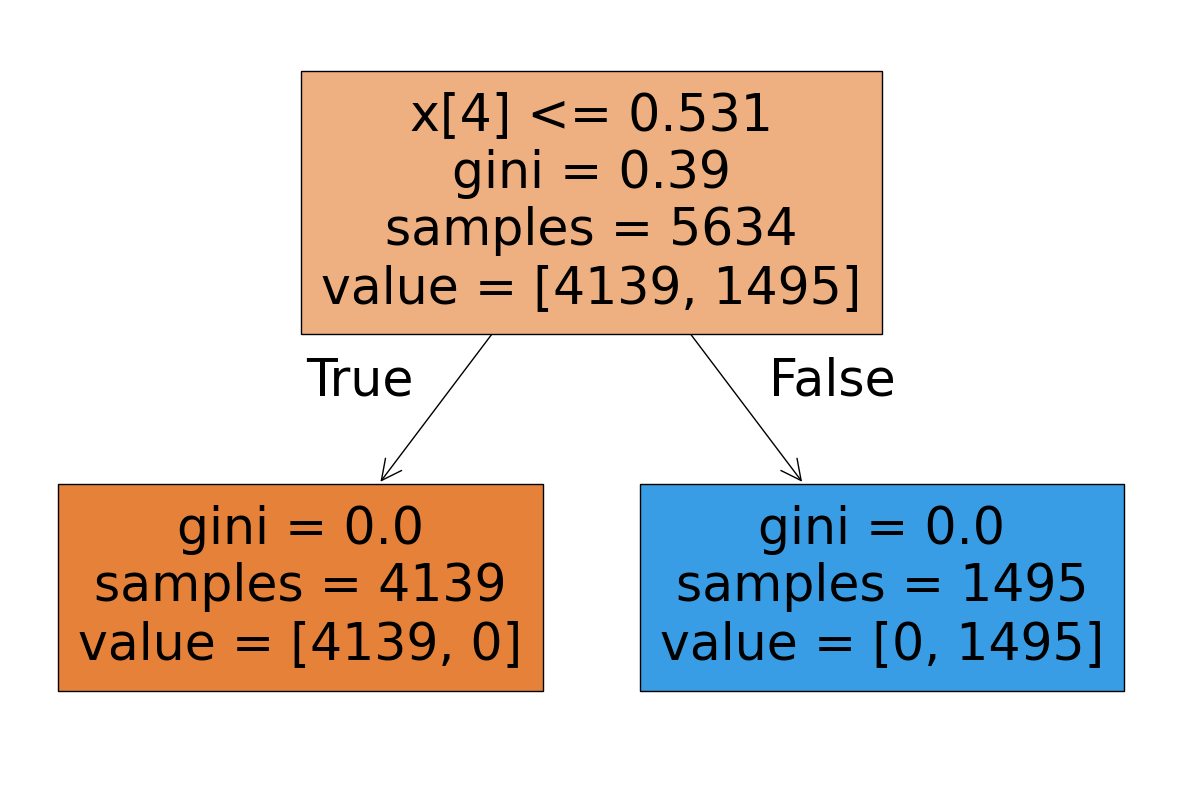

In [28]:
# Extract the trained DecisionTreeClassifier from your pipeline
clf = best_dt.named_steps['clf']

# Plot the tree (simple version)
plt.figure(figsize=(15,10))
tree.plot_tree(clf, filled=True)
plt.show()

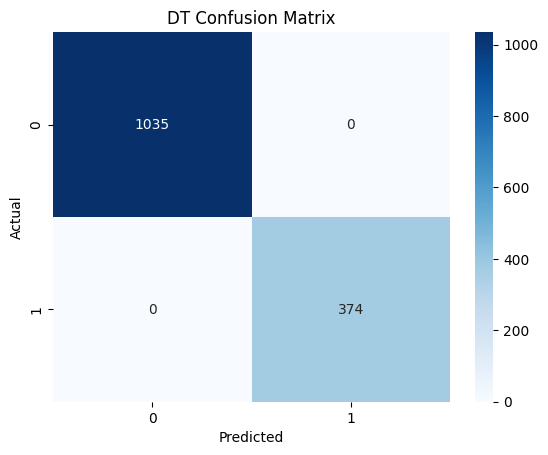

In [29]:
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('DT Confusion Matrix')
plt.show()

In [30]:
# Predicted probabilities
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_score_dt = auc(fpr_dt, tpr_dt)


In [31]:
# ROC Curve
def plot_roc_curve(fpr, tpr, auc_score, model_name="Model"):
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='orange', label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()


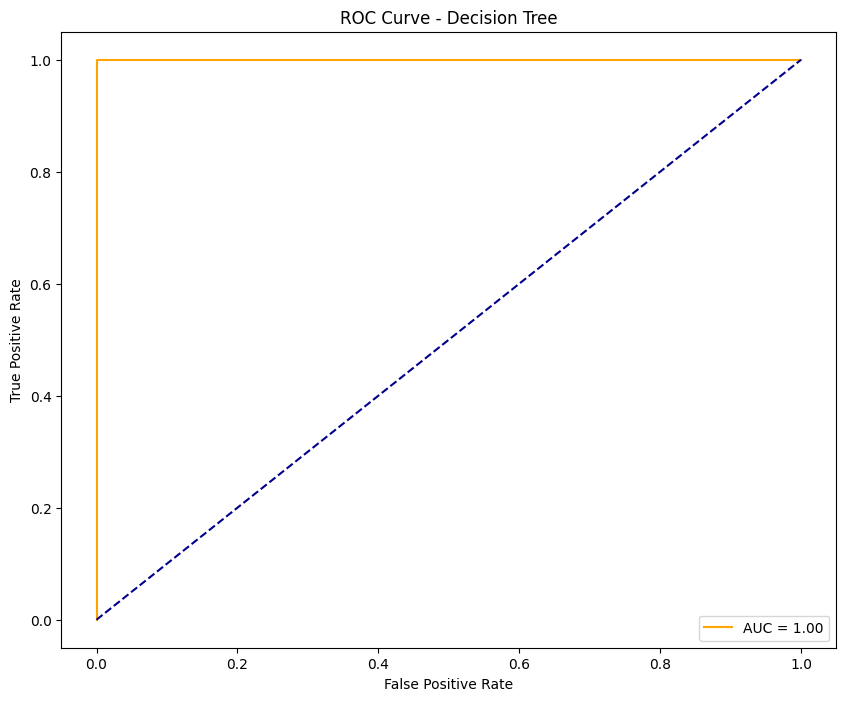

In [32]:
plot_roc_curve(fpr_dt, tpr_dt, auc_score_dt, model_name="Decision Tree")


In [33]:
# Pruning

# Extract preprocessed training & test data from the pipeline
X_train_pp = best_dt.named_steps['preproc'].transform(X_train)
X_test_pp  = best_dt.named_steps['preproc'].transform(X_test)

# Extract the raw decision tree classifier
clf = best_dt.named_steps['clf']


In [34]:
path = clf.cost_complexity_pruning_path(X_train_pp, y_train)
ccp_alphas = path.ccp_alphas


In [35]:
clfs = []

for alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    dt.fit(X_train_pp, y_train)
    clfs.append(dt)

# Choose alpha that gives best accuracy on test set
test_scores = [clf.score(X_test_pp, y_test) for clf in clfs]

best_index = test_scores.index(max(test_scores))
best_alpha = ccp_alphas[best_index]

print("Best alpha:", best_alpha)


Best alpha: 0.0


In [36]:
pruned_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_dt.fit(X_train_pp, y_train)


DecisionTreeClassifier(ccp_alpha=np.float64(0.0), random_state=42)

In [37]:
from sklearn.metrics import classification_report

y_pred_pruned = pruned_dt.predict(X_test_pp)

print("Pruned Decision Tree Performance:")
print(classification_report(y_test, y_pred_pruned))


Pruned Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



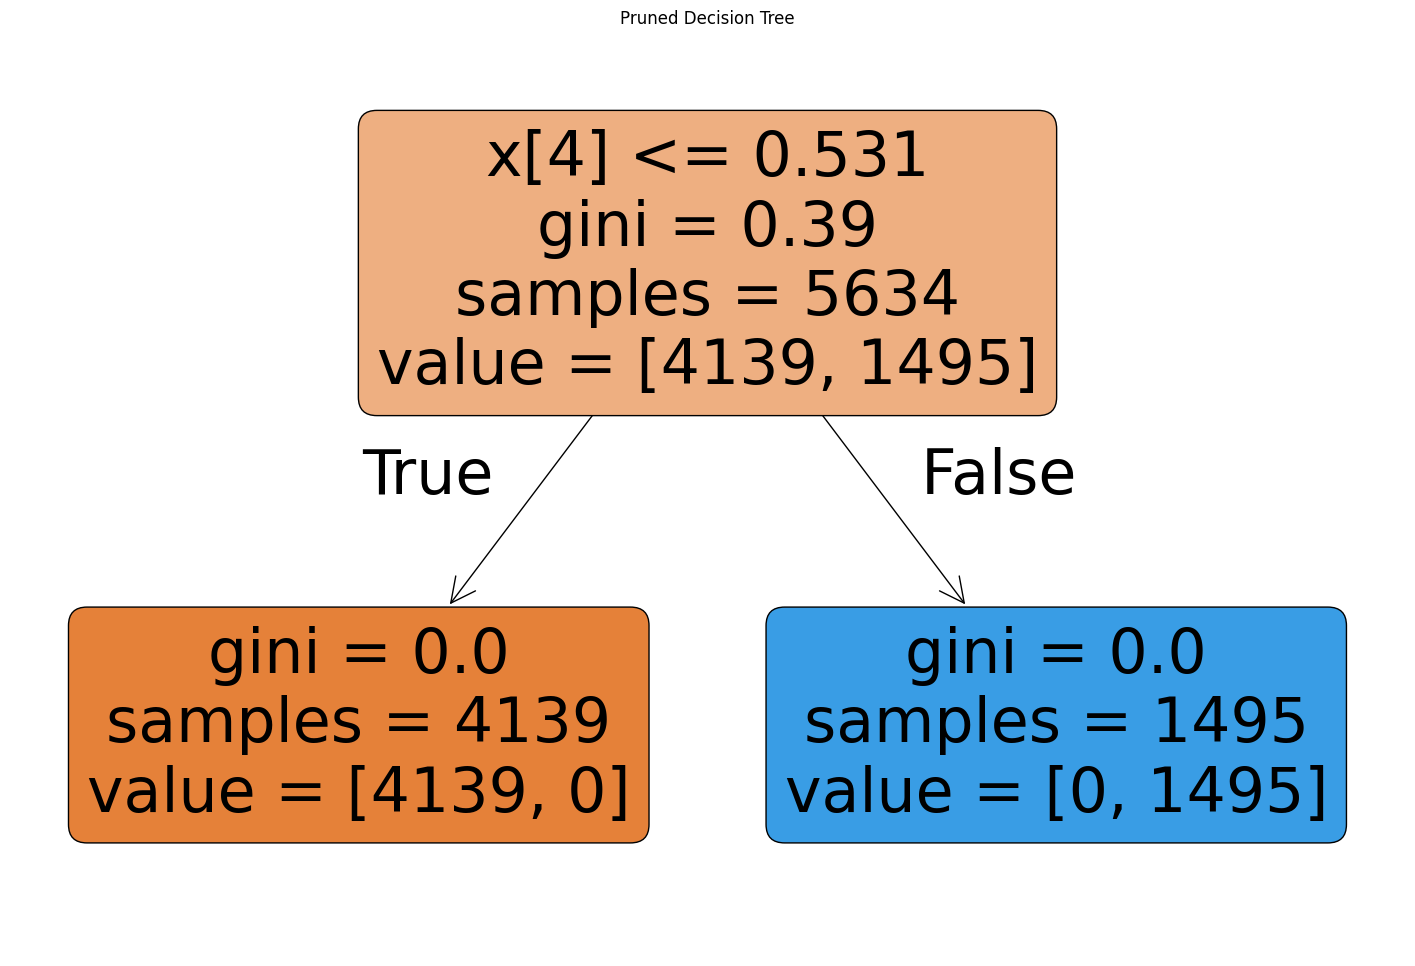

In [38]:
from sklearn import tree
plt.figure(figsize=(18,12))
tree.plot_tree(pruned_dt, filled=True, rounded=True)
plt.title("Pruned Decision Tree")
plt.show()


### Neural Network

In [41]:
# Preprocess data using  existing preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# Convert sparse → dense
X_train_np = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_np  = X_test_processed.toarray()  if hasattr(X_test_processed, "toarray")  else X_test_processed

y_train_np = y_train.values
y_test_np  = y_test.values

input_dim = X_train_np.shape[1]
print("Input dimension for ANN:", input_dim)


Input dimension for ANN: 46


In [43]:
def build_and_train_nn(units, layers_count, dropout, epochs=30, batch_size=64):
    model = Sequential()

    # Input layer + first hidden
    model.add(Dense(units, activation="relu", input_dim=input_dim))
    if dropout > 0:
        model.add(Dropout(dropout))

    # Additional hidden layers
    for i in range(layers_count - 1):
        model.add(Dense(units, activation="relu"))
        if dropout > 0:
            model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    model.fit(
        X_train_np, y_train_np,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # Evaluate
    y_pred_prob = model.predict(X_test_np).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    acc = accuracy_score(y_test_np, y_pred)

    return model, acc


In [48]:
tuning_results = []

for units in [32, 64]:
    for layers_count in [1, 2]:
        for dropout in [0.0, 0.3]:
            model, acc = build_and_train_nn(units, layers_count, dropout)
            tuning_results.append({
                'units': units,
                'layers': layers_count,
                'dropout': dropout,
                'accuracy': acc
            })
            print(f"units={units}, layers={layers_count}, dropout={dropout} → accuracy={acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=32, layers=1, dropout=0.0 → accuracy=1.0000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=32, layers=1, dropout=0.3 → accuracy=1.0000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=32, layers=2, dropout=0.0 → accuracy=1.0000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=32, layers=2, dropout=0.3 → accuracy=1.0000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=64, layers=1, dropout=0.0 → accuracy=1.0000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=64, layers=1, dropout=0.3 → accuracy=1.0000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=64, layers=2, dropout=0.0 → accuracy=1.0000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=64, layers=2, dropout=0.3 → accuracy=1.0000


In [49]:
best_config = max(tuning_results, key=lambda x: x['accuracy'])
best_config


{'units': 32, 'layers': 1, 'dropout': 0.0, 'accuracy': 1.0}

In [50]:
best_units = best_config['units']
best_layers = best_config['layers']
best_dropout = best_config['dropout']

print("Training final ANN with:", best_config)

final_model, _ = build_and_train_nn(
    units=best_units,
    layers_count=best_layers,
    dropout=best_dropout,
    epochs=60,
    batch_size=32
)


Training final ANN with: {'units': 32, 'layers': 1, 'dropout': 0.0, 'accuracy': 1.0}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


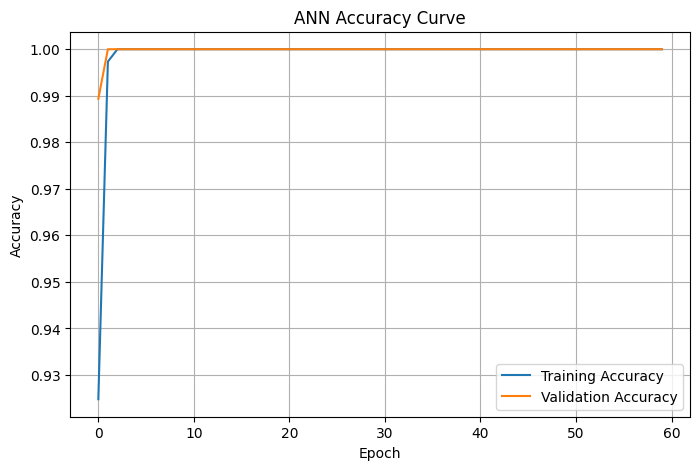

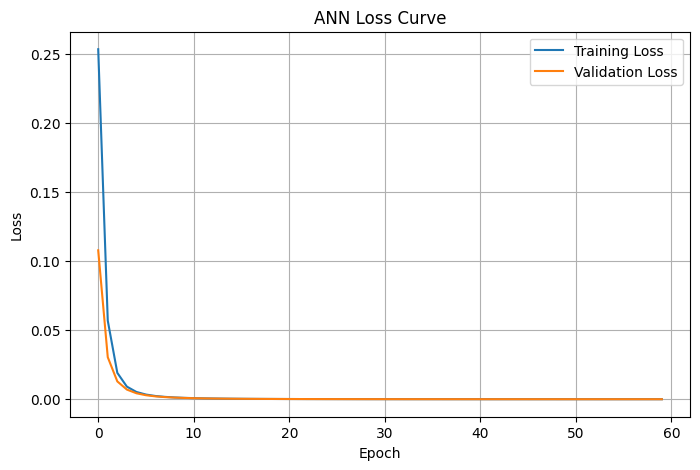

In [51]:
history = final_model.history  # saved from training


# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("ANN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("ANN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [52]:

y_pred_prob = final_model.predict(X_test_np).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Final ANN Evaluation:")
print("Accuracy:", accuracy_score(y_test_np, y_pred))
print("Precision:", precision_score(y_test_np, y_pred))
print("Recall:", recall_score(y_test_np, y_pred))
print("F1 Score:", f1_score(y_test_np, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_np, y_pred_prob))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Final ANN Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



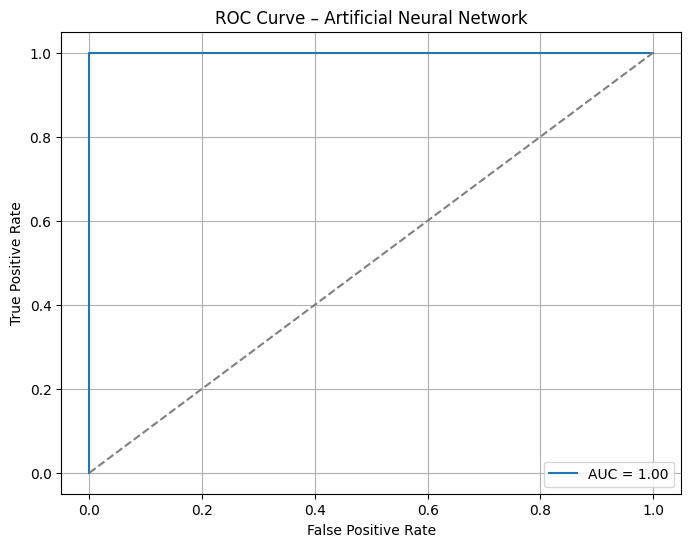

In [53]:
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob)
roc_value = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_value:.2f}")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Artificial Neural Network")
plt.legend()
plt.grid(True)
plt.show()
